# Predicting NYC Taxi Fares with RAPIDS

[RAPIDS](https://rapids.ai/) is a suite of GPU accelerated data science libraries with APIs that should be familiar to users of Pandas, Dask, and Scikitlearn.

Anaconda has graciously made some of the NYC Taxi dataset available in [a public Google Cloud Storage bucket](https://console.cloud.google.com/storage/browser/anaconda-public-data/nyc-taxi/csv/). We have already cleaned up the column names a bit and re-saved a single month of the data. (For a larger-scale exercise, consider adapting this script to handle a full year via Dask!)

This notebook builds a simple data pipeline to load the data with cuDF (or Pandas), analyze it with cuML (or scikit-learn), and then try some steps with multiple GPUs.

In [1]:
import numpy as np
import pandas as pd
import cuml
import cudf
import os

# Inspecting the Data

Let's start with a familiar Pandas approach then port it to RAPIDS in parallel

In [249]:
%%time
# Pandas

# df = pd.read_orc('yellow_tripdata_2014-03-cleaned.orc')
df = pd.read_orc('https://odsc-sample-data.s3-us-west-2.amazonaws.com/yellow_tripdata_2014-03-cleaned.orc')
df.head()

CPU times: user 3.27 s, sys: 2.9 s, total: 6.17 s
Wall time: 1min 8s


,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
0,2014-03-01 01:07:38,2014-03-01 01:16:26,1,2.0,-73.951508,40.714111,1,-73.944275,40.690678,9.0
1,2014-03-01 01:08:03,2014-03-01 01:12:51,2,1.2,-74.004738,40.742172,1,-73.992226,40.748211,6.0
2,2014-03-01 01:08:51,2014-03-01 01:13:18,3,0.5,-73.949303,40.707569,1,-73.951653,40.714249,5.0
3,2014-03-01 01:09:20,2014-03-01 01:24:18,3,3.5,-73.993538,40.721298,1,-73.961433,40.760410,14.0
4,2014-03-01 01:09:46,2014-03-01 01:22:34,1,1.8,-73.987885,40.744579,1,-74.004387,40.722775,10.5


In [6]:
%%time
# TODO: Read the CSV with cudf into 'gdf' and display the first few rows

# *** Answer: ***

# gdf = cudf.read_orc('yellow_tripdata_2014-03-cleaned.orc')
gdf = cudf.read_orc('https://odsc-sample-data.s3-us-west-2.amazonaws.com/yellow_tripdata_2014-03-cleaned.orc')


gdf.head()

CPU times: user 141 ms, sys: 113 ms, total: 255 ms
Wall time: 253 ms


,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
0,2014-03-01 01:07:38,2014-03-01 01:16:26,1,2.0,-73.951508,40.714111,1,-73.944275,40.690678,9.0
1,2014-03-01 01:08:03,2014-03-01 01:12:51,2,1.2,-74.004738,40.742172,1,-73.992226,40.748211,6.0
2,2014-03-01 01:08:51,2014-03-01 01:13:18,3,0.5,-73.949303,40.707569,1,-73.951653,40.714249,5.0
3,2014-03-01 01:09:20,2014-03-01 01:24:18,3,3.5,-73.993538,40.721298,1,-73.961433,40.760410,14.0
4,2014-03-01 01:09:46,2014-03-01 01:22:34,1,1.8,-73.987885,40.744579,1,-74.004387,40.722775,10.5


# Look at some key stats

In [7]:
import seaborn as sns

/home/jzedlewski/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


When passing data to functions that expect Pandas DataFrames, we just use ".to_pandas()"

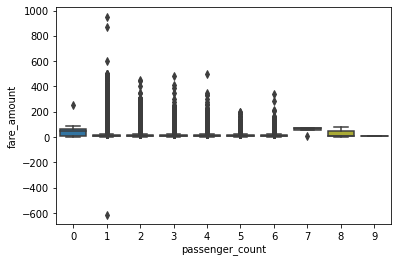

In [8]:
sns.boxplot(x="passenger_count", y="fare_amount", data=gdf.to_pandas())

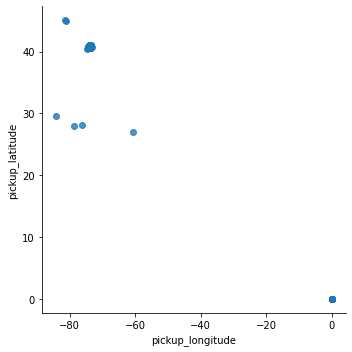

In [9]:
sns.lmplot(x="pickup_longitude", y="pickup_latitude",
           data=gdf.head(100000).to_pandas(),
           fit_reg=False,
           x_jitter=0.01, y_jitter=0.01)

# Filter the data

Ok, there are some WEIRD latitudes and longitudes in that data. Let's filter to just sane stuff.

In [10]:
%%time

# apply a list of filter conditions to throw out records with missing or outlier values
query_frags = [
    'fare_amount > 0 and fare_amount < 500',
    'passenger_count > 0 and passenger_count < 6',
    'pickup_longitude > -75.0 and pickup_longitude < -73.0',
    'dropoff_longitude > -75 and dropoff_longitude < -73',
    'pickup_latitude > 40 and pickup_latitude < 42',
    'dropoff_latitude > 40 and dropoff_latitude < 42'
]
df_subset = df.query(' and '.join(query_frags)).copy()

# inspect the results of cleaning
df_subset.head()

CPU times: user 1.43 s, sys: 2.02 s, total: 3.45 s
Wall time: 1.17 s


,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
0,2014-03-01 01:07:38,2014-03-01 01:16:26,1,2.0,-73.951508,40.714111,1,-73.944275,40.690678,9.0
1,2014-03-01 01:08:03,2014-03-01 01:12:51,2,1.2,-74.004738,40.742172,1,-73.992226,40.748211,6.0
2,2014-03-01 01:08:51,2014-03-01 01:13:18,3,0.5,-73.949303,40.707569,1,-73.951653,40.714249,5.0
3,2014-03-01 01:09:20,2014-03-01 01:24:18,3,3.5,-73.993538,40.721298,1,-73.961433,40.760410,14.0
4,2014-03-01 01:09:46,2014-03-01 01:22:34,1,1.8,-73.987885,40.744579,1,-74.004387,40.722775,10.5


In [11]:
%%time

# TODO: RAPIDS version with "gdf_subset" as output

# *** Answer:
gdf_subset = gdf.query(' and '.join(query_frags)).copy()
gdf_subset.head()

CPU times: user 308 ms, sys: 23.3 ms, total: 331 ms
Wall time: 335 ms


,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
0,2014-03-01 01:07:38,2014-03-01 01:16:26,1,2.0,-73.951508,40.714111,1,-73.944275,40.690678,9.0
1,2014-03-01 01:08:03,2014-03-01 01:12:51,2,1.2,-74.004738,40.742172,1,-73.992226,40.748211,6.0
2,2014-03-01 01:08:51,2014-03-01 01:13:18,3,0.5,-73.949303,40.707569,1,-73.951653,40.714249,5.0
3,2014-03-01 01:09:20,2014-03-01 01:24:18,3,3.5,-73.993538,40.721298,1,-73.961433,40.760410,14.0
4,2014-03-01 01:09:46,2014-03-01 01:22:34,1,1.8,-73.987885,40.744579,1,-74.004387,40.722775,10.5


# Demo 3: UDFs to add rich features 

cuDF provides standard DataFrame operations, but also let you run "user defined functions" on the underlying data.

cuDF's [apply_rows](https://rapidsai.github.io/projects/cudf/en/0.6.0/api.html#cudf.dataframe.DataFrame.apply_rows) operation is similar to Pandas's [DataFrame.apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html), except that for cuDF, custom Python code is [JIT compiled by numba](https://numba.pydata.org/numba-doc/dev/cuda/kernels.html) into GPU kernels.

We'll use a Haversine Distance calculation to find total trip distance, and extract additional useful variables from the datetime fields.

In [12]:
from numpy import pi

def haversine_distance_kernel_cpu(row):
    x_1, y_1, x_2, y_2 = (row["pickup_latitude"], row["pickup_longitude"], row["dropoff_latitude"], row["dropoff_longitude"])
    x_1 = pi/180 * x_1
    y_1 = pi/180 * y_1
    x_2 = pi/180 * x_2
    y_2 = pi/180 * y_2

    dlon = y_2 - y_1
    dlat = x_2 - x_1
    a = np.sin(dlat/2)**2 + np.cos(x_1) * np.cos(x_2) * np.sin(dlon/2)**2

    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers
        
    return c * r
        
def add_features(df):
    df['hour'] = df['pickup_datetime'].dt.hour
    df['year'] = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day'] = df['pickup_datetime'].dt.day
    
    df['pickup_latitude_r'] = df['pickup_latitude']//.01*.01
    df['pickup_longitude_r'] = df['pickup_longitude']//.01*.01
    df['dropoff_latitude_r'] = df['dropoff_latitude']//.01*.01
    df['dropoff_longitude_r'] = df['dropoff_longitude']//.01*.01
    df["day_of_week"] = df["pickup_datetime"].dt.dayofweek
    
    df = df.drop(columns=['pickup_datetime', 'dropoff_datetime'])    
    
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(np.int32)
    return df

In [13]:
%%time

# actually add the features
taxi_df = add_features(df_subset)

CPU times: user 8.49 s, sys: 2 s, total: 10.5 s
Wall time: 9.37 s


In [14]:
%%time
# compute distance
taxi_df["h_distance"] = haversine_distance_kernel_cpu(taxi_df)

CPU times: user 3.94 s, sys: 2.73 s, total: 6.67 s
Wall time: 1.13 s


## cuDF version with UDF

cuDF's [apply_rows](https://rapidsai.github.io/projects/cudf/en/0.6.0/api.html#cudf.dataframe.DataFrame.apply_rows) operation is similar to Pandas's [DataFrame.apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html), except that for cuDF, custom Python code is [JIT compiled by numba](https://numba.pydata.org/numba-doc/dev/cuda/kernels.html) into GPU kernels.

In [15]:
import math
from math import cos, sin, asin, sqrt, pi

def haversine_distance_kernel_gpu(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude, h_distance):
    for i, (x_1, y_1, x_2, y_2) in enumerate(zip(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude)):
        x_1 = pi/180 * x_1
        y_1 = pi/180 * y_1
        x_2 = pi/180 * x_2
        y_2 = pi/180 * y_2
        
        dlon = y_2 - y_1
        dlat = x_2 - x_1
        a = sin(dlat/2)**2 + cos(x_1) * cos(x_2) * sin(dlon/2)**2
        
        c = 2 * asin(sqrt(a)) 
        r = 6371 # Radius of earth in kilometers
        
        h_distance[i] = c * r
  
def add_features_gpu(df):
    df['hour'] = df['pickup_datetime'].dt.hour
    df['year'] = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day'] = df['pickup_datetime'].dt.day
    
    df['pickup_latitude_r'] = df['pickup_latitude']//.01*.01
    df['pickup_longitude_r'] = df['pickup_longitude']//.01*.01
    df['dropoff_latitude_r'] = df['dropoff_latitude']//.01*.01
    df['dropoff_longitude_r'] = df['dropoff_longitude']//.01*.01
    df["day_of_week"] = df["pickup_datetime"].dt.dayofweek
    
    df = df.drop(columns=['pickup_datetime', 'dropoff_datetime'])    
 
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(np.int32)
    return df

def compute_distance_gpu(df):
    df = df.apply_rows(haversine_distance_kernel_gpu,
                   incols=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'],
                   outcols=dict(h_distance=np.float32),
                   kwargs=dict())
    return df

In [17]:
%%time

# TODO: actually add the features and create "taxi_gdf" from gdf_subset

# Answer
taxi_gdf = add_features_gpu(gdf_subset)

CPU times: user 1.06 s, sys: 53 ms, total: 1.12 s
Wall time: 1.14 s


In [24]:
%%time

# TODO: add the distance calculation

# *** Answer
taxi_gdf = compute_distance_gpu(taxi_gdf)

CPU times: user 18.3 ms, sys: 21 ms, total: 39.3 ms
Wall time: 37.6 ms


For more advanced spatial calculations, check out cuSpatial (https://medium.com/rapids-ai/releasing-cuspatial-to-accelerate-geospatial-and-spatiotemporal-processing-b686d8b32a9), the newest RAPIDS library.

In [28]:
%%time

# TODO: Print summary stats from "taxi_gdf"

# *** Answer:
taxi_gdf.describe()

CPU times: user 470 ms, sys: 211 ms, total: 681 ms
Wall time: 678 ms


,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount,hour,year,month,day,pickup_latitude_r,pickup_longitude_r,dropoff_latitude_r,dropoff_longitude_r,day_of_week,is_weekend,h_distance
count,1.456764e+07,1.456764e+07,1.456764e+07,1.456764e+07,1.456764e+07,1.456764e+07,1.456764e+07,1.456764e+07,1.456764e+07,14567636.0,14567636.0,1.456764e+07,1.456764e+07,1.456764e+07,1.456764e+07,1.456764e+07,1.456764e+07,1.456764e+07,1.456764e+07
mean,1.528328e+00,3.874029e+00,-7.397624e+01,4.075072e+01,1.029330e+00,-7.397437e+01,4.075101e+01,1.218589e+01,1.353601e+01,2014.0,3.0,1.590566e+01,4.074580e+01,-7.398132e+01,4.074607e+01,-7.397945e+01,3.152615e+00,3.326060e-01,3.341314e+00
std,1.084497e+00,2.040333e+03,3.281800e-02,2.667300e-02,3.170100e-01,3.446600e-02,3.168800e-02,9.939481e+00,6.520118e+00,0.0,0.0,8.945232e+00,2.685900e-02,3.282800e-02,3.182600e-02,3.450000e-02,2.029983e+00,4.711470e-01,3.624085e+00
min,1.000000e+00,0.000000e+00,-7.499645e+01,4.004641e+01,0.000000e+00,-7.499645e+01,4.000129e+01,1.000000e-02,0.000000e+00,2014.0,3.0,1.000000e+00,4.004000e+01,-7.500000e+01,4.000000e+01,-7.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.010000e+00,-7.399229e+01,4.073626e+01,1.000000e+00,-7.399159e+01,4.073477e+01,6.500000e+00,9.000000e+00,2014.0,3.0,8.000000e+00,4.073000e+01,-7.400000e+01,4.073000e+01,-7.400000e+01,1.000000e+00,0.000000e+00,1.255070e+00
50%,1.000000e+00,1.740000e+00,-7.398225e+01,4.075300e+01,1.000000e+00,-7.398057e+01,4.075348e+01,9.000000e+00,1.400000e+01,2014.0,3.0,1.600000e+01,4.075000e+01,-7.399000e+01,4.075000e+01,-7.399000e+01,3.000000e+00,0.000000e+00,2.158259e+00
75%,2.000000e+00,3.200000e+00,-7.396896e+01,4.076692e+01,1.000000e+00,-7.396453e+01,4.076837e+01,1.400000e+01,1.900000e+01,2014.0,3.0,2.400000e+01,4.076000e+01,-7.397000e+01,4.076000e+01,-7.397000e+01,5.000000e+00,1.000000e+00,3.940165e+00
max,5.000000e+00,5.005013e+06,-7.304270e+01,4.189384e+01,2.100000e+02,-7.300692e+01,4.189384e+01,4.800000e+02,2.300000e+01,2014.0,3.0,3.100000e+01,4.189000e+01,-7.305000e+01,4.189000e+01,-7.301000e+01,6.000000e+00,1.000000e+00,1.410381e+02


# Pick a Training Set

Let's imagine you're making a trip to New York on the 24th and want to build a model to predict what fare prices will be like the last few days of the month based on the first part of the month. We'll use a query expression to identify the `day` of the month to use to divide the data into train and test sets.

The wall-time below represents how long it takes your GPU cluster to load data from the Google Cloud Storage bucket and the ETL portion of the workflow.

In [214]:
%%time
from sklearn.model_selection import train_test_split as sk_train_test_split

X_np = taxi_df.drop(columns='fare_amount').to_numpy()
Y_np = taxi_df[["fare_amount"]].to_numpy()

X_train_np, X_test_np, Y_train_np, Y_test_np = sk_train_test_split(X_np, Y_np, test_size=0.2)

CPU times: user 4.2 s, sys: 1.05 s, total: 5.25 s
Wall time: 5.24 s


In [217]:
%%time
from cuml.preprocessing.model_selection import train_test_split as cu_train_test_split

X_gpu = taxi_gdf.drop(columns='fare_amount').values.astype("float32")
Y_gpu = taxi_gdf[["fare_amount"]].values.astype("float32")

X_train_gpu, X_test_gpu, Y_train_gpu, Y_test_gpu = cu_train_test_split(X_gpu,
                                                                        Y_gpu,
                                                                        test_size=0.2)

CPU times: user 1.24 s, sys: 109 ms, total: 1.35 s
Wall time: 1.37 s


# Demo 4: Cluster and analyze with cuML

In [218]:
%matplotlib inline

In [219]:
import sklearn, sklearn.cluster
from matplotlib import pyplot as plt

In [220]:
%%time
# use scikit-learn on CPU

sk_kmeans = sklearn.cluster.KMeans(n_clusters=5)
train_clusters_cpu = sk_kmeans.fit_predict(X_train_np)

CPU times: user 2min 46s, sys: 1min 53s, total: 4min 39s
Wall time: 41.8 s


In [221]:
%%time
# n_samples = 400000

# TODO: use cuML on GPU to fit KMeans with 5 clusters (larger dataset)

# *** Answer:
import cuml.cluster
gdf_numeric = gdf.select_dtypes(include="float")
cu_kmeans = cuml.cluster.KMeans(n_clusters=5)
train_clusters_gpu = cu_kmeans.fit_predict(X_train_gpu)

CPU times: user 438 ms, sys: 227 ms, total: 666 ms
Wall time: 663 ms


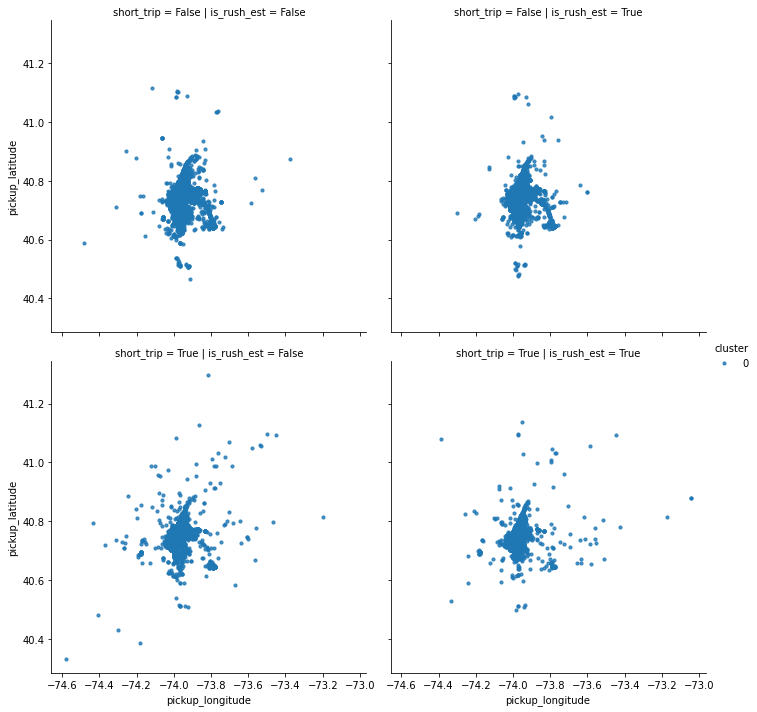

In [222]:
# Just take a subset to speed plotting
gdf_train_head = X_train_gdf.iloc[:400000]
gdf_train_head["cluster"] = train_clusters_gpu[:400000]
gdf_train_head["short_trip"] = gdf_train_head["trip_distance"] < 1.01 # About the 25th percentile
gdf_train_head["is_rush_est"] = ((gdf_train_head.hour >= 10) & (gdf_train_head.hour <= 14)) | \
                                ((gdf_train_head.hour >= 21) & (gdf_train_head.hour <= 24))

# actually do the plot
sns.lmplot("pickup_longitude", "pickup_latitude", data=gdf_train_head.to_pandas(),
           hue="cluster", col="is_rush_est", row="short_trip", fit_reg=False, scatter_kws={"s": 10})

### Fit a simple supervised model with cuML

cuML supports a large range of supervised models, all emulating the scikit-learn interfaces. See the README (https://github.com/rapidsai/cuml) for a recent list. Here, we'll try a very simple model - an ElasticNet regularized regression with both L1 and L2 regularization. As a user exercise, try replacing this with a RandomForestRegressor or a simpler LinearRegression.

In [241]:
from sklearn.linear_model import ElasticNet as skElasticNet

In [242]:
%%time
# Sklearn will parallelize over all CPU cores with n_jobs=-1
sk_model = skElasticNet()
sk_model.fit(X_train_np, Y_train_np)

CPU times: user 7.11 s, sys: 1.05 s, total: 8.16 s
Wall time: 3.56 s


ElasticNet()

In [243]:
from sklearn.metrics.regression import r2_score as sk_r2_score

print("Within-sample (training) R2: ", r2_score(Y_test_np, sk_model.predict(X_test_np)))

Within-sample (training) R2:  0.740240752696991


In [246]:
%%time

# TODO: Build a similar model on GPU with cuML

# *** Answer:
from cuml.linear_model import ElasticNet as cuElasticNet
cu_model = cuElasticNet(alpha=0.1)
cu_model.fit(X_train_gpu, Y_train_gpu)

CPU times: user 81.2 ms, sys: 80.6 ms, total: 162 ms
Wall time: 160 ms


ElasticNet(alpha=0.1, l1_ratio=0.5, fit_intercept=True, normalize=False, max_iter=1000, tol=0.001, selection='cyclic', handle=<cuml.raft.common.handle.Handle object at 0x7fa2f059efd0>, output_type='cupy')

In [248]:
%%time

# TODO: Predict on the test set and evaluate the predictions' R2 score

# *** Answer
from cuml.metrics.regression import r2_score

Y_hat_gpu = cu_model.predict(X_test_gpu)
r2_score(Y_test_gpu, Y_hat_gpu)

CPU times: user 3.56 ms, sys: 23.6 ms, total: 27.2 ms
Wall time: 25.6 ms


0.7627811431884766

# Demo 5: Train an  XGBoost Regression Model

XGBoost is one of the most popular packages for gradient boosted decision trees. It comes with excellent GPU acceleration out of the box.

In [172]:
%%time
# Train on CPU (uses all CPUs by default)
import xgboost

params = {
 'learning_rate': 0.3,
  'max_depth': 6,

  'subsample': 0.6,
  'gamma': 1
}

train_dmat = xgboost.DMatrix(X_train_np, Y_train_np, feature_names=X_train_df.columns)
print("Converted to dmatrix")
trained_model = xgboost.train(params, train_dmat, num_boost_round=5)

Converted to dmatrix
[21:18:37] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1601407842448/work/src/gbm/gbtree.cc:147: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
CPU times: user 7min 44s, sys: 2min 22s, total: 10min 7s
Wall time: 40.6 s


In [197]:
%%time

# TODO: retrain on GPU for more rounds, saving model as trained_model_gpus

# *** Answer:
params = {
 'learning_rate': 0.3,
  'max_depth': 6,
  'tree_method': 'gpu_hist',
  'subsample': 0.6,
  'gamma': 1
}

train_dmat = xgboost.DMatrix(X_train_np, Y_train_np, feature_names=X_train_df.columns)
print("Converted to dmatrix")
trained_model_gpu = xgboost.train(params, train_dmat, num_boost_round=50)

Converted to dmatrix
CPU times: user 13 s, sys: 8.08 s, total: 21.1 s
Wall time: 8.76 s


# How Good is Our Model?

Now that we have a trained model, we need to test it with the ecords we held out.

In [198]:
%%time

# TODO: generate predictions on the test set as Y_test_gdf['prediction']

# *** Answer:
# Note that we can pass in a cuDF dataframe withotu conversion
test_dmat = xgboost.DMatrix(X_test_gdf)

Y_test_gdf['prediction'] = trained_model_gpu.predict(test_dmat)

CPU times: user 67.6 ms, sys: 7.78 ms, total: 75.4 ms
Wall time: 73.6 ms


In [199]:
Y_test_gdf['prediction']

813929       9.263096
835025      10.238948
837538       8.353477
838538      19.707085
840424       8.027554
              ...    
15426937     5.512997
15426938     4.308615
15426939    13.304368
15426940     9.101547
15426941    11.307952
Name: prediction, Length: 3691100, dtype: float32

# Compute Root Mean Squared Error

In [200]:
Y_test_gdf["squared_error"] = (Y_test_gdf['prediction'] - Y_test_gdf['fare_amount'])**2

# inspect the results to make sure our calculation looks right
Y_test_gdf.head()

,fare_amount,prediction,squared_error
813929,9.0,9.263096,0.069219
835025,9.5,10.238948,0.546044
837538,8.5,8.353477,0.021469
838538,23.0,19.707085,10.843291
840424,9.0,8.027554,0.945652


In [201]:
# compute the actual RMSE over the full test set
np.sqrt(Y_test_gdf.squared_error.mean())

2.1353587768950693

# Save Trained Model for Later Use

To make a model maximally useful, you need to be able to save it for later use.

In [202]:
# Save model
trained_model_gpu.save_model("output.model")